### Library imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.datasets import fetch_openml


from sklearn_extra.robust import RobustWeightedClassifier
    
pd.set_option('display.max_columns', 300) # Display up to 300 columns from pandas

## TOC:
* [Loading the dataset](#dataset)
* [Classification Study](#classification)
* [Exploration of why it works](#exploration)
* [Annex: Selection of Hyperparameters](#annex)

## Loading the Dataset <a class="anchor" id="dataset"></a>

The dataset is adapted from https://archive.ics.uci.edu/ml/datasets/heart+disease. If one is interested, there are a large number of EDA made on this dataset in kaggle notebooks.

In [2]:
X, y = fetch_openml(data_id=982, as_frame=True, return_X_y=True)

In [3]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,male,typ_angina,145.0,233.0,t,left_vent_hyper,150.0,no,2.3,down,0.0,fixed_defect
1,67.0,male,asympt,160.0,286.0,f,left_vent_hyper,108.0,yes,1.5,flat,3.0,normal
2,67.0,male,asympt,120.0,229.0,f,left_vent_hyper,129.0,yes,2.6,flat,2.0,reversable_defect
3,37.0,male,non_anginal,130.0,250.0,f,normal,187.0,no,3.5,down,0.0,normal
4,41.0,female,atyp_angina,130.0,204.0,f,left_vent_hyper,172.0,no,1.4,up,0.0,normal


In [4]:
X.shape

(303, 13)

The dataset is not very large and there are both categorical and numerical features.

In [5]:
X.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          5
thal        2
dtype: int64

There is a small number of missing data in the dataset. 
We replace those with a common value for the given feature.

In [6]:
X['thal'] = X['thal'].fillna('normal')
X['ca'] = X['ca'].fillna('0')

Let us plot the counting tables of the categorical features.

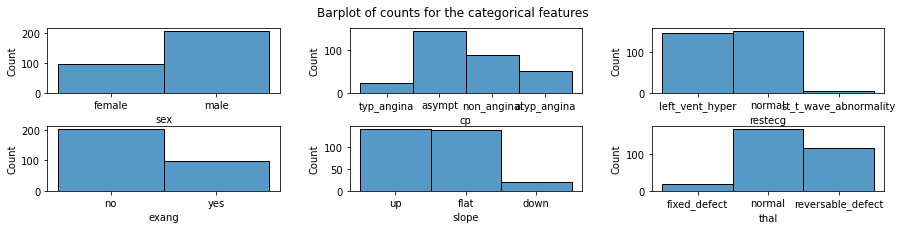

In [7]:
plt.figure(figsize=(15,3))
plt.subplot(2,3,1)
sns.histplot(data=X, x="sex", bins=10)
plt.subplot(2,3,2)
sns.histplot(data=X, x="cp")
plt.subplot(2,3,3)
sns.histplot(data=X, x="restecg")
plt.subplot(2,3,4)
sns.histplot(data=X, x="exang")
plt.subplot(2,3,5)
sns.histplot(data=X, x="slope")
plt.subplot(2,3,6)
sns.histplot(data=X, x="thal")
plt.suptitle('Barplot of counts for the categorical features')
plt.subplots_adjust(wspace=0.3, hspace=0.5)

The categorical features do not have a lot of different values. They can be one-hot encoded.

In [8]:
X = pd.get_dummies(X, drop_first=False)
X.columns

Index(['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'sex_female',
       'sex_male', 'cp_typ_angina', 'cp_asympt', 'cp_non_anginal',
       'cp_atyp_angina', 'fbs_t', 'fbs_f', 'restecg_left_vent_hyper',
       'restecg_normal', 'restecg_st_t_wave_abnormality', 'exang_no',
       'exang_yes', 'slope_up', 'slope_flat', 'slope_down', 'ca_0.0', 'ca_1.0',
       'ca_2.0', 'ca_3.0', 'ca_0', 'thal_fixed_defect', 'thal_normal',
       'thal_reversable_defect'],
      dtype='object')

In [9]:
y = (y == 'P').astype('int') # replace binary y by 0 and 1

In [10]:
np.mean(y)

0.5445544554455446

The target is well balanced between 0 and 1. No unbalanced dataset.

In [11]:
# Resulting dataset
X.head()

,age,trestbps,chol,thalach,oldpeak,sex_female,sex_male,cp_typ_angina,cp_asympt,cp_non_anginal,cp_atyp_angina,fbs_t,fbs_f,restecg_left_vent_hyper,restecg_normal,restecg_st_t_wave_abnormality,exang_no,exang_yes,slope_up,slope_flat,slope_down,ca_0.0,ca_1.0,ca_2.0,ca_3.0,ca_0,thal_fixed_defect,thal_normal,thal_reversable_defect
0,63.0,145.0,233.0,150.0,2.3,0,1,1,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0
1,67.0,160.0,286.0,108.0,1.5,0,1,0,1,0,0,0,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0
2,67.0,120.0,229.0,129.0,2.6,0,1,0,1,0,0,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1
3,37.0,130.0,250.0,187.0,3.5,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0
4,41.0,130.0,204.0,172.0,1.4,1,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0


## Classification Study <a class="anchor" id="classification"></a>

### Definition of the estimator.

scikit-learn-extra estimators use SGDClassifier as base estimator hence we need to scale the data.
Being in a Robust framework, we use RobustScaler.

In [12]:
RWE_huber = Pipeline(steps=[('scaler', RobustScaler()),
                ('clf', RobustWeightedClassifier(burn_in=0, c=1))])

In [13]:
lr = LogisticRegression()
rf = RandomForestClassifier(max_depth= 5)
svm = SVC(C=0.1, kernel='linear')

### Evaluations

In [14]:
from sklearn.model_selection import StratifiedKFold
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

**Warning:** Logistic Regression does not converge in this dataset, we remove the warnings to avoid cluttered outputs.

In [15]:
print('Linear Regression accuracy: %.4F ' %(np.mean(cross_val_score(lr,X,y,cv=10))))
print('Random Forest accuracy: %.4F ' %(np.mean(cross_val_score(rf,X,y,cv=10))))
print('SVM accuracy: %.4F ' %(np.mean(cross_val_score(svm,X,y,cv=10))))

Linear Regression accuracy: 0.8578 
Random Forest accuracy: 0.8380 
SVM accuracy: 0.8381 


In [16]:
print("Robust Weighted Estimator accuracy: %.4F " %(np.mean(cross_val_score(RWE_huber,X,y,cv=10))))

Robust Weighted Estimator accuracy: 0.8481 


The highest score is $0.8578$ which is close to the highest score in openml $0.8581$. For now, Logistic Regression gives the best result.

Next, we try to increase the score by using Polynomial features introducing non-linear behavior.

In [17]:
RWE_huber_poly = Pipeline(steps=[('scaler', RobustScaler()), ('features', PolynomialFeatures()),
                ('clf',RobustWeightedClassifier(burn_in=0, c=0.5, eta0=0.005))])

In [18]:
print("Robust Weighted Estimator with polynomial features accuracy: %.4F " 
      %(np.mean(cross_val_score(RWE_huber_poly,X,y,cv=10))))

Robust Weighted Estimator with polynomial features accuracy: 0.8680 


Remark that the same process is not efficient for Logistic Regression.

In [19]:
log_poly = Pipeline(steps=[('scaler', RobustScaler()), ('features', PolynomialFeatures()),
                ('clf',LogisticRegression())])

In [20]:
print("Logistic Regression with polynomial features accuracy: %.4F " 
      %(np.mean(cross_val_score(log_poly,X,y,cv=10))))

Logistic Regression with polynomial features accuracy: 0.7983 


## Exploration of why it works <a class="anchor" id="exporation"></a>

First, let us visualize the weights learned by our estimator. Those are meant to are interpreted as some "outlier score"

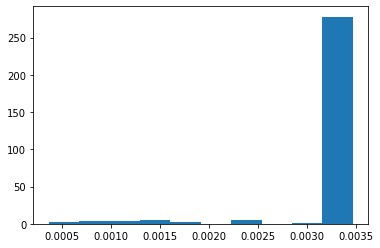

In [21]:
scal = RobustScaler()
pol = PolynomialFeatures()
X_why = pol.fit_transform(scal.fit_transform(X))
RWE_huber = RobustWeightedClassifier(burn_in=0, c=0.5, eta0=0.005, multi_class='binary')
RWE_huber.fit(X_why,y)
plt.hist(RWE_huber.weights_)
plt.show()

In [22]:
numerical_columns = ["age","trestbps","chol", "thalach", "oldpeak"]

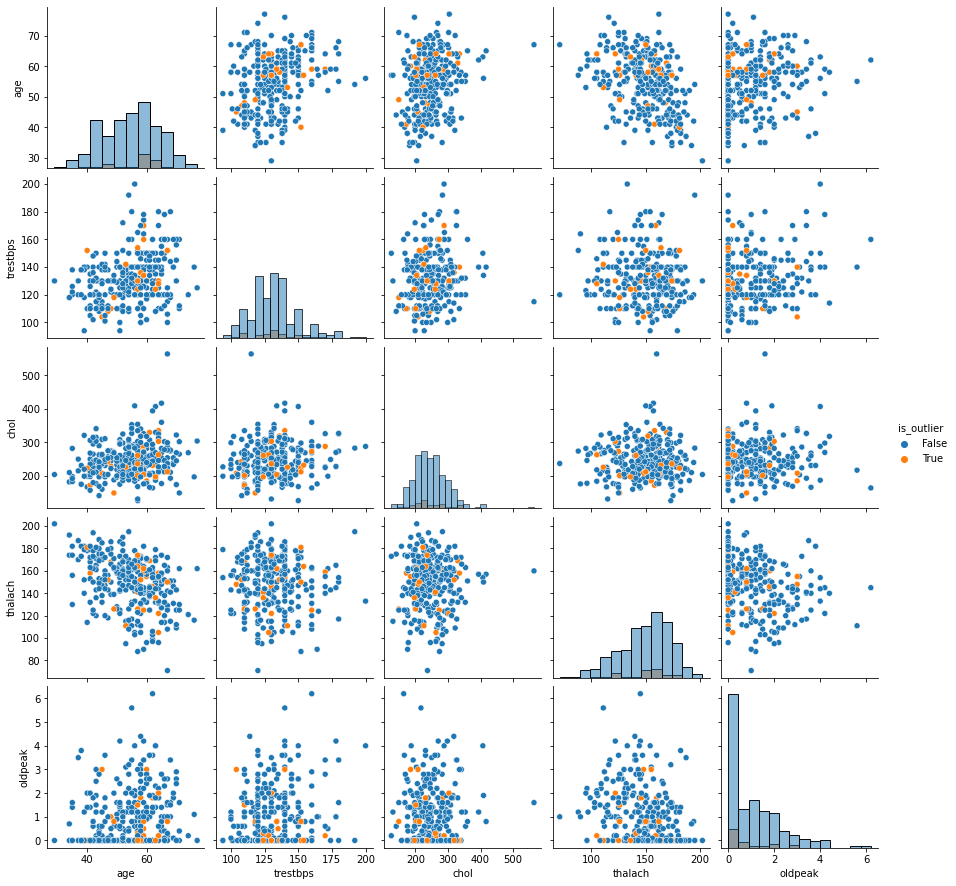

In [23]:
X_plot, y_plot = fetch_openml(data_id=982, as_frame=True, return_X_y=True)
sns.pairplot(data=X_plot[numerical_columns].assign(is_outlier=RWE_huber.weights_ < 0.003)
            ,hue='is_outlier', diag_kind= 'hist')

The visualization in one and two dimensions of numerical features do not seem to give us any insight on why our algorithm chose these points as outliers. 
There may be two reasons:
* Our algorithm wrongly interepreted these points as outliers
* The reason why these points are outliers depend on the qualititative features and is possibly high dimensional.

To check this, let us see whether removing outliers thanks to our algorithm when using Logistic Regression can help the Logistic Regression. We compute the Stratified K-Fold by hand because outlier removal is not easy to pipeline in scikit-learn.

In [24]:
skf = StratifiedKFold(10)
res = []
clf = LogisticRegression()
for train, test in skf.split(X,y):
    X_train, y_train = X.loc[train], y.loc[train]
    X_test, y_test = X.loc[test], y.loc[test]
    clf.fit(X_train, y_train)
    res += [np.mean(clf.predict(X_test)==y_test)]
print(np.mean(res))

0.8578494623655913


In [25]:

pol = PolynomialFeatures()
skf = StratifiedKFold(10)
res = []
for train, test in skf.split(X,y):
    X_train, y_train = X.loc[train], y.loc[train]
    X_test, y_test = X.loc[test], y.loc[test]
    scal = RobustScaler()
    X_train = scal.fit_transform(X_train)
    X_test = scal.transform(X_test)
    
    X_train = pol.fit_transform(X_train)
    X_test = pol.transform(X_test)
    RWE_huber.fit(X_train, y_train)
    weights = RWE_huber.weights_
    threshold = np.sort(weights)[2]
    #X_train, y_train = X_train[weights>threshold], y_train.loc[weights>threshold]     
    clf.fit(X_train, y_train)
    res += [np.mean(clf.predict(X_test)==y_test)]
print(np.mean(res))

0.7982795698924731


In [26]:

pol = PolynomialFeatures()
skf = StratifiedKFold(10)
res = []
for train, test in skf.split(X,y):
    X_train, y_train = X.loc[train], y.loc[train]
    X_test, y_test = X.loc[test], y.loc[test]
    scal = RobustScaler()
    X_train = scal.fit_transform(X_train)
    X_test = scal.transform(X_test)
    
    X_train = pol.fit_transform(X_train)
    X_test = pol.transform(X_test)
    RWE_huber.fit(X_train, y_train)
    weights = RWE_huber.weights_
    threshold = np.sort(weights)[15]
    X_train, y_train = X_train[weights>threshold], y_train.loc[weights>threshold]     
    clf.fit(X_train, y_train)
    res += [np.mean(clf.predict(X_test)==y_test)]
print(np.mean(res))

0.8679569892473118


The Logistic Regression algorithm with Polynomial Feature works a lot better with outlier removal than without. Hence, it seems that the outliers we removed were indeed outliers even though it is not clear at all on the low-dimensional visualizations. 

## Annex: hyperparameter tuning. <a class="anchor" id="annex"></a>

In [27]:
parameters = {'clf__c':[1e-2,1e-1,0.5,1,10]
                        , 
              'clf__loss':['log','hinge'],
              'clf__burn_in':[0, 5, 10],
              'clf__eta0':[1e-4,1e-3,1e-2,1e-1]
             }
rwe =  Pipeline([('scaler',RobustScaler()), 
                      ('clf',RobustWeightedClassifier())])
clf = GridSearchCV(rwe, parameters, cv=10)
clf.fit(X, y)
print(clf.best_estimator_, clf.best_score_)

Pipeline(steps=[('scaler', RobustScaler()),
                ('clf', RobustWeightedClassifier(burn_in=0, c=1, eta0=0.001))]) 0.8513978494623655


In [28]:
from sklearn.preprocessing import PolynomialFeatures

parameters = {'clf__c':[1e-3,1e-2,1e-1,1,2,5,10], 
              'clf__loss':['log','hinge'],
              'clf__burn_in':[0, 5, 10],
              'clf__eta0':[1e-4,5e-4,1e-3,5e-3, 1e-2,1e-1]
             }
rwe =  Pipeline([('scaler',RobustScaler()), ('features',PolynomialFeatures(interaction_only=True)), 
                      ('clf',RobustWeightedClassifier())])
clf = GridSearchCV(rwe, parameters, cv=10)
clf.fit(X, y)
print(clf.best_estimator_, clf.best_score_)

Pipeline(steps=[('scaler', RobustScaler()),
                ('features', PolynomialFeatures(interaction_only=True)),
                ('clf',
                 RobustWeightedClassifier(burn_in=0, c=0.1, eta0=0.005,
                                          loss='hinge'))]) 0.867741935483871


We can also see that for instance Random Forest and SVM are not as efficient as our approach.

In [29]:
parameters = {'n_estimators':[50,100,200,500],
              "max_depth":[None, 5, 10, 15],
             }
rf =  RandomForestClassifier()
clf = GridSearchCV(rf, parameters, cv=10)
clf.fit(X, y)
print(clf.best_estimator_, clf.best_score_) 

RandomForestClassifier(max_depth=5, n_estimators=50) 0.8412903225806451


In [30]:
parameters = {'C':[1e-3, 1e-1, 1, 10],
              "kernel":['linear','poly', 'rbf'],
             }
svm =  SVC()
clf = GridSearchCV(svm, parameters, cv=10)
clf.fit(X, y)
print(clf.best_estimator_, clf.best_score_) 

SVC(C=0.1, kernel='linear') 0.8380645161290323
